In [56]:
import networkx as nx
import random as rng
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import csv
from tqdm import tqdm

In [118]:
class Ant:

    def __init__(self, position, path):
        self.path = []
        self.position = position
    
    def pickup_deliver(self, g, orders, beta):
        
        # return home when no orders left
        if orders == []:
            if self.position != 1:
                self.path.append((self.position, 1))
                self.position = 1

        else:
            paths = []
            for i in orders:
                if (self.position,i[0]) not in paths:
                    paths.append((self.position,i[0]))


            reweight_flag = False
            if (g[i]["weight"] == 0 for i in paths):
                for i in paths:
                    g.edges[i]["weight"] = 1
                    reweight_flag = True


            # move ant on randomly chosen path to pickup location according to pheremone weights
            path = rng.choices(paths, (g.edges[paths[i]]["weight"]/g.edges[paths[i]]["distance"]**beta for i in range(0,len(paths))))[0]
            self.path.append(path)
            self.position = path[1]

            if reweight_flag:
                for i in paths:
                        g.edges[i]["weight"] = 0
                        reweight_flag = False

            # randomly choose order to deliver according to pheremone paths
            paths = []

            for i in orders:
                if i[0] == self.position:
                    paths.append(i)

            if (paths[i]["weight"] == 0 for i in paths):
                for i in paths:
                    g.edges[i]["weight"] = 1
                    reweight_flag = True

            path = rng.choices(paths, (g.edges[paths[i]]["weight"]/g.edges[paths[i]]["distance"]**beta for i in range(0,len(paths))))[0]
            self.path.append(path)
            self.position = path[1]

            if reweight_flag:
                for i in paths:
                    g.edges[i]["weight"] = 0
                    reweight_flag = False

            orders.remove(self.path[-1])

In [119]:
class Colony:

    def __init__(self,n, pher, evap, beta, orders):
        self.ants = []
        self.evap = evap
        self.pher = pher
        self.beta = beta
        for i in range(0,n): self.ants.append(Ant(1,[]))
        self.orders = orders

    def move(self, g):
        for i in self.ants:
            i.pickup_deliver(g, self.orders, self.beta)

    def fulfill(self, g):
        while self.orders != []:
                self.move(g)

        self.move(g)
            

        solution = []

        for i in self.ants:
            solution.append(i.path)

        return solution

    def update(self, g, sol):

        for i in g.edges:
            g.edges[i]["weight"] = (1-self.evap)* g.edges[i]["weight"]
            if g.edges[i]["weight"] < 0:
                g.edges[i]["weight"] = 0
        
        for i in sol:
            for j in i:
                g.edges[j]["weight"] += self.pher/g.edges[j]["distance"]
                if g.edges[j]["weight"] < 0:
                    g.edges[j]["weight"] = 0
                


In [136]:
K = widgets.FloatSlider(min=0.0,max=100.0,step=0.1, value=10, description = "K (pheremone)")
V = widgets.FloatSlider(min=0.0,max=1.0,step=0.01, value=0.5, description = "V (evaporation rate)")
N = widgets.IntSlider(min=1,max=100, value=10, description = "N (iterations)")
B = widgets.FloatSlider(min=0.0,max=4,step=0.1, value=2, description = "Greediness")

In [121]:
path = "forest_sets_with_csv/data/mod_forestset1_nodes.csv"

rows = []
with open(path, newline='') as csvfile:
    nodes = csv.reader(csvfile)
    next(nodes)

    for row in nodes:
        rows.append(row)

node_coords = []
node_types = []

for i in rows:
    node_coords.append((int(i[0]),int(i[1])))
    node_types.append(i[2])

In [122]:
path = "forest_sets_with_csv/data/mod_forestset1_orders.csv"

rows = []
with open(path, newline='') as csvfile:
    orders = csv.reader(csvfile)
    next(orders)

    for row in orders:
        rows.append(row)

order_tuples = []

for i in rows:
    order_tuples.append((int(i[0]),int(i[1])))

In [154]:
g = nx.DiGraph()
g.add_nodes_from(range(1,len(node_coords)+1))

for i in g.nodes():
    for j in g.nodes():
        g.add_edge(i,j, weight=1, orders = 0)

for i in order_tuples:
    g.edges[i[0],i[1]]["orders"] +=1


for i in g.nodes():
    g.nodes[i]['x'] = node_coords[i-1][0]
    g.nodes[i]['y'] = node_coords[i-1][1]
    g.nodes[i]["type"] = node_types[i-1]

for i in g.edges():
    g.edges[i]["distance"] = np.sqrt((g.nodes[i[1]]["x"] - g.nodes[i[0]]["x"])**2 + (g.nodes[i[1]]["y"] - g.nodes[i[0]]["y"])**2)


In [147]:
display(N)
display(K)
display(V)
display(B)

IntSlider(value=10, description='N (iterations)', min=1)

FloatSlider(value=19.400000000000002, description='K (pheremone)')

FloatSlider(value=0.17, description='V (evaporation rate)', max=1.0, step=0.01)

FloatSlider(value=0.0, description='Greediness', max=4.0)

In [165]:
# This cell solves and plots the paths

for i in g.edges:
    g.edges[i]["weight"] = 1


solution = []

orders = order_tuples.copy()
iteration_num = N.value
colony = Colony(40, K.value, V.value, B.value, orders)

print("Finding solutions and iterating...")
for i in tqdm(range(iteration_num)):
    orders = order_tuples.copy()

    colony.__init__(40, K.value, V.value, B.value, orders)
    
    solution = colony.fulfill(g)

    colony.update(g, solution)

solution = colony.fulfill(g)

def distance(path):
    distance = 0
    for i in path:
        distance += g.edges[i]["distance"]
    
    return distance

pher_max = max(list(g.edges[i]["weight"] for i in g.edges))
print("Max pheremone: " + str(pher_max))
print("Total distance traversed: " + str(sum(map(distance, solution))))
print("Orders distance: " + str(sum(map(distance, list(solution[i][1::2] for i in range(len(solution)))))))
print("Deadhead: " + str(sum(map(distance, list(solution[i][::2] for i in range(len(solution)))))))

Finding solutions and iterating...


100%|██████████| 100/100 [00:03<00:00, 28.99it/s]

Max pheremone: 6.324555320336759
Total distance traversed: 35714694.44778882
Orders distance: 18456286.3830882
Deadhead: 17258408.064700633



 Calculating and plotting pheremone network...


100%|██████████| 6241/6241 [00:03<00:00, 1998.23it/s]


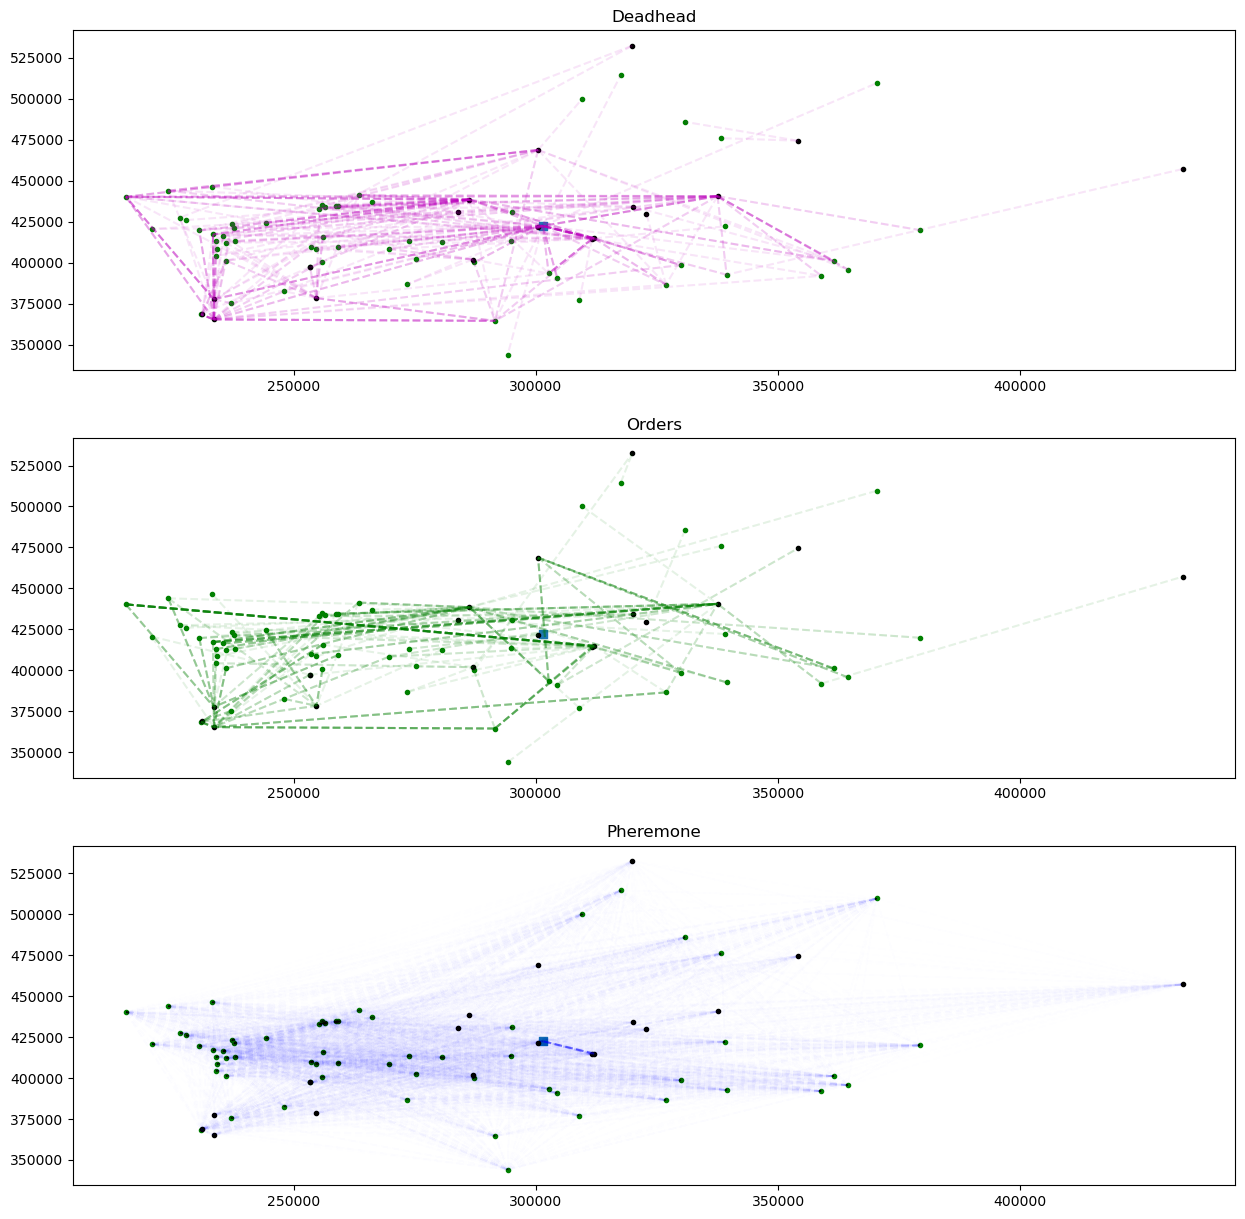

In [166]:
x_forests = []
y_forests = []

x_sawmills = []
y_sawmills = []


for i in g.nodes():
    if g.nodes[i]["type"] == "forest": 
        x_forests.append(g.nodes[i]['x'])
        y_forests.append(g.nodes[i]['y'] )

    if g.nodes[i]["type"] == "sawmill": 
        x_sawmills.append(g.nodes[i]['x'])
        y_sawmills.append(g.nodes[i]['y'] )


fig, ax = plt.subplots(3,1, figsize=(15,15))

def plot_path(path,ax, col):
    for i in path:
        ax.plot([g.nodes[i[0]]['x'], g.nodes[i[1]]['x']], [g.nodes[i[0]]['y'], g.nodes[i[1]]['y']], color=col, linestyle="--", alpha=0.1)


for i in range(3):
    ax[i].scatter(g.nodes[1]['x'],g.nodes[1]['y'], marker="s")
    ax[i].scatter(x_forests,y_forests, c="green", marker=".")
    ax[i].scatter(x_sawmills,y_sawmills, c="black", marker=".")

ax[0].set_title("Deadhead")
ax[1].set_title("Orders")
ax[2].set_title("Pheremone")

for i in solution:
    plot_path(i[::2],ax[0], "m")

for i in solution:
    plot_path(i[1::2],ax[1], "g")


print("\n Calculating and plotting pheremone network...")
for i in tqdm(g.edges):
    ax[2].plot([g.nodes[i[0]]['x'], g.nodes[i[1]]['x']], [g.nodes[i[0]]['y'], g.nodes[i[1]]['y']], color="b", linestyle="--", alpha=g.edges[i]["weight"]/pher_max)